
Columnas disponibles:
['User_ID', 'Age', 'Gender', 'Occupation', 'Country', 'Mental_Health_Condition', 'Severity', 'Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours', 'Social_Media_Usage', 'Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Medication_Usage']

Distribución de Mental_Health_Condition:
Mental_Health_Condition
No     25003
Yes    24997
Name: count, dtype: int64


C:\Users\abiel\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:02:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


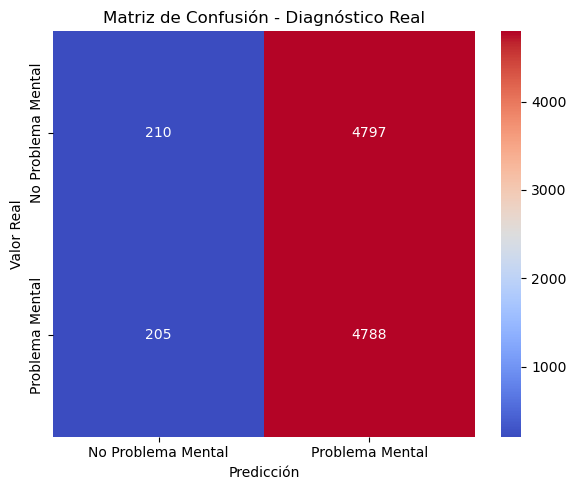


Reporte de Clasificación - Diagnóstico Real:
                    precision    recall  f1-score   support

No Problema Mental       0.51      0.04      0.08      5007
   Problema Mental       0.50      0.96      0.66      4993

          accuracy                           0.50     10000
         macro avg       0.50      0.50      0.37     10000
      weighted avg       0.50      0.50      0.37     10000



In [12]:
# --- 1. Cargar el dataset ---
import pandas as pd
import shap

df_diagnostico = pd.read_csv('mental_health_data final data.csv')

# --- 2. Verificar estructura básica ---
print("\nColumnas disponibles:")
print(df_diagnostico.columns.tolist())

print("\nDistribución de Mental_Health_Condition:")
print(df_diagnostico['Mental_Health_Condition'].value_counts())

# --- 3. Preparar variables predictoras y objetivo ---

# Definir features que vamos a usar
features_diagnostico = [
    'Age', 'Gender', 'Occupation', 'Country', 'Severity', 'Consultation_History',
    'Stress_Level', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours',
    'Social_Media_Usage', 'Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Medication_Usage'
]

# Copiar solo esas columnas más la variable objetivo
df_model_diagnostico = df_diagnostico[features_diagnostico + ['Mental_Health_Condition']].copy()

# --- 4. Binarizar la variable objetivo ---
# Mental_Health_Condition: 'Yes' -> 1, 'No' -> 0
mental_health_mapping = {'Yes': 1, 'No': 0}
df_model_diagnostico = df_model_diagnostico[df_model_diagnostico['Mental_Health_Condition'].isin(['Yes', 'No'])]
df_model_diagnostico['target'] = df_model_diagnostico['Mental_Health_Condition'].map(mental_health_mapping)
df_model_diagnostico = df_model_diagnostico.drop(columns=['Mental_Health_Condition'])

# --- 5. Codificar variables categóricas ---
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in ['Gender', 'Occupation', 'Country', 'Severity', 'Consultation_History',
            'Stress_Level', 'Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Medication_Usage']:
    df_model_diagnostico[col] = le.fit_transform(df_model_diagnostico[col])

# --- 6. División de datos ---
from sklearn.model_selection import train_test_split
X_diag = df_model_diagnostico.drop(columns='target')
y_diag = df_model_diagnostico['target']

X_train_diag, X_test_diag, y_train_diag, y_test_diag = train_test_split(X_diag, y_diag, test_size=0.2, random_state=42)

# --- 7. Aplicar SMOTE si es necesario ---
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced_diag, y_train_balanced_diag = smote.fit_resample(X_train_diag, y_train_diag)

# --- 8. Entrenar XGBoost Tuned ---
from xgboost import XGBClassifier

xgb_diag = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=4,
    learning_rate=0.1,
    n_estimators=300,
    scale_pos_weight=len(y_train_balanced_diag[y_train_balanced_diag == 0]) / len(y_train_balanced_diag[y_train_balanced_diag == 1])
)

xgb_diag.fit(X_train_balanced_diag, y_train_balanced_diag)

# --- 9. Predecir y evaluar ---
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_probs_diag = xgb_diag.predict_proba(X_test_diag)[:, 1]
threshold = 0.4
y_pred_diag = (y_probs_diag >= threshold).astype(int)

# --- Matriz de Confusión ---
cm_diag = confusion_matrix(y_test_diag, y_pred_diag)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_diag, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['No Problema Mental', 'Problema Mental'],
            yticklabels=['No Problema Mental', 'Problema Mental'])
plt.title('Matriz de Confusión - Diagnóstico Real')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

# --- Reporte de Clasificación ---
print("\nReporte de Clasificación - Diagnóstico Real:")
print(classification_report(y_test_diag, y_pred_diag, target_names=['No Problema Mental', 'Problema Mental']))


In [14]:
# --- Random Forest ---
from sklearn.ensemble import RandomForestClassifier

rf_diag = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=None
)

rf_diag.fit(X_train_balanced_diag, y_train_balanced_diag)

# Predicción Random Forest
y_pred_rf = rf_diag.predict(X_test_diag)

print("\nReporte de Clasificación - Random Forest (Diagnóstico Real):")
print(classification_report(y_test_diag, y_pred_rf, target_names=['No Problema Mental', 'Problema Mental']))

# --- Logistic Regression ---
from sklearn.linear_model import LogisticRegression

lr_diag = LogisticRegression(
    random_state=42,
    max_iter=1000
)

lr_diag.fit(X_train_balanced_diag, y_train_balanced_diag)

# Predicción Logistic Regression
y_pred_lr = lr_diag.predict(X_test_diag)

print("\nReporte de Clasificación - Logistic Regression (Diagnóstico Real):")
print(classification_report(y_test_diag, y_pred_lr, target_names=['No Problema Mental', 'Problema Mental']))

# --- XGBoost Tuned ---
from xgboost import XGBClassifier

xgb_diag = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=4,
    learning_rate=0.1,
    n_estimators=300,
    scale_pos_weight=len(y_train_balanced_diag[y_train_balanced_diag == 0]) / len(y_train_balanced_diag[y_train_balanced_diag == 1])
)

xgb_diag.fit(X_train_balanced_diag, y_train_balanced_diag)

# Predicción XGBoost
y_probs_diag = xgb_diag.predict_proba(X_test_diag)[:, 1]
threshold = 0.4
y_pred_xgb = (y_probs_diag >= threshold).astype(int)

print("\nReporte de Clasificación - XGBoost Tuned (Diagnóstico Real):")
print(classification_report(y_test_diag, y_pred_xgb, target_names=['No Problema Mental', 'Problema Mental']))



Reporte de Clasificación - Random Forest (Diagnóstico Real):
                    precision    recall  f1-score   support

No Problema Mental       0.50      0.53      0.52      5007
   Problema Mental       0.50      0.47      0.49      4993

          accuracy                           0.50     10000
         macro avg       0.50      0.50      0.50     10000
      weighted avg       0.50      0.50      0.50     10000


Reporte de Clasificación - Logistic Regression (Diagnóstico Real):
                    precision    recall  f1-score   support

No Problema Mental       0.50      0.50      0.50      5007
   Problema Mental       0.50      0.50      0.50      4993

          accuracy                           0.50     10000
         macro avg       0.50      0.50      0.50     10000
      weighted avg       0.50      0.50      0.50     10000



C:\Users\abiel\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:03:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Reporte de Clasificación - XGBoost Tuned (Diagnóstico Real):
                    precision    recall  f1-score   support

No Problema Mental       0.51      0.04      0.08      5007
   Problema Mental       0.50      0.96      0.66      4993

          accuracy                           0.50     10000
         macro avg       0.50      0.50      0.37     10000
      weighted avg       0.50      0.50      0.37     10000



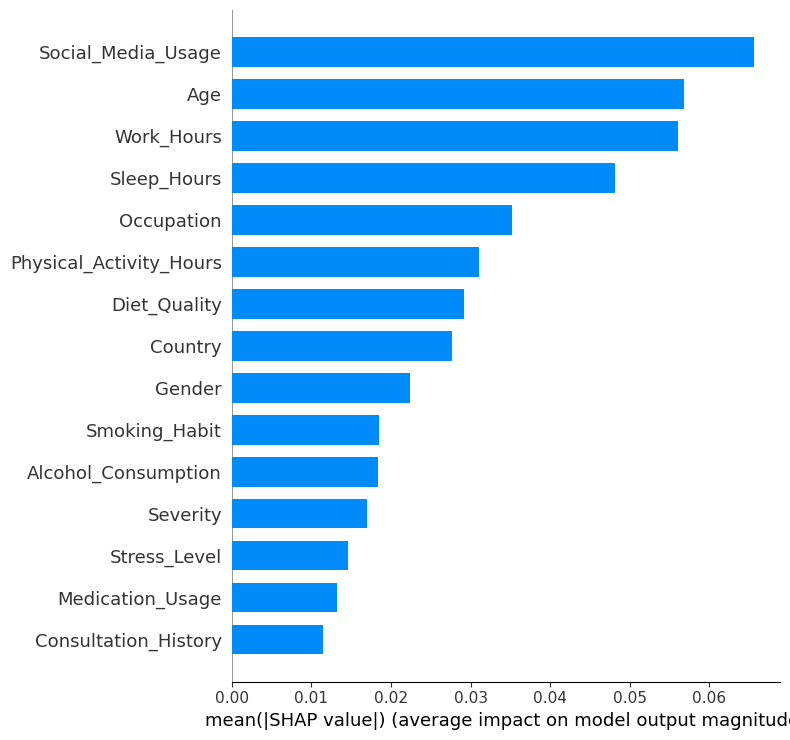


Predicción para muestra individual (Diagnóstico Real):
Age                        27.0
Gender                      0.0
Occupation                  1.0
Country                     0.0
Severity                    1.0
Consultation_History        1.0
Stress_Level                1.0
Sleep_Hours                 6.8
Work_Hours                 35.0
Physical_Activity_Hours     1.0
Social_Media_Usage          2.9
Diet_Quality                2.0
Smoking_Habit               2.0
Alcohol_Consumption         1.0
Medication_Usage            0.0
Name: 33553, dtype: float64


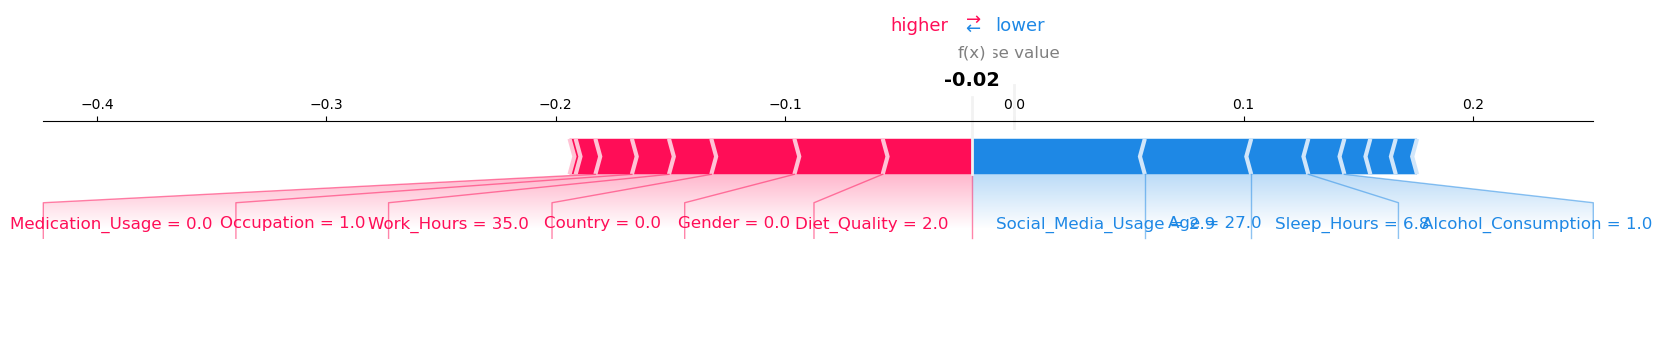

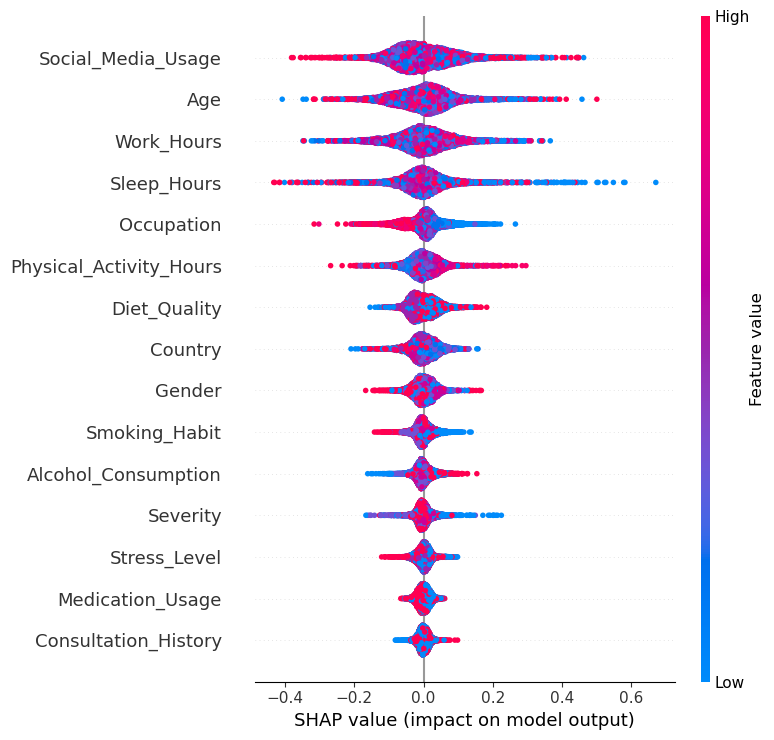

In [16]:
# --- 1. Importar librerías necesarias ---
import shap
import matplotlib.pyplot as plt

# --- 2. Crear explainer de SHAP para el modelo de diagnóstico real ---
explainer_diag = shap.TreeExplainer(xgb_diag)

# --- 3. Calcular los SHAP values sobre el set de prueba ---
shap_values_diag = explainer_diag.shap_values(X_test_diag)

# --- 4. Importancia Global de Variables (Barplot) ---
plt.title('Importancia Global de Variables (SHAP) - Diagnóstico Real')
shap.summary_plot(shap_values_diag, X_test_diag, plot_type="bar")
plt.show()

# --- 5. Interpretación individual para un ejemplo (opcional) ---
sample_index = 0  # Cambia el número para ver otras muestras

print("\nPredicción para muestra individual (Diagnóstico Real):")
print(X_test_diag.iloc[sample_index])

shap.force_plot(
    explainer_diag.expected_value,
    shap_values_diag[sample_index, :],
    X_test_diag.iloc[sample_index, :],
    matplotlib=True
)

# --- 6. Dispersión de Importancia y Valores (Summary Scatter Plot) ---
shap.summary_plot(shap_values_diag, X_test_diag, plot_type="dot")


In [22]:
# --- 1. Importar librerías ---
import lime
import lime.lime_tabular
import numpy as np

# --- 2. Preparar el explainer de LIME ---
explainer_lime_diag = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_balanced_diag),
    feature_names=X_train_balanced_diag.columns.tolist(),
    class_names=['No Problema Mental', 'Problema Mental'],
    mode='classification'
)

# --- 3. Elegir una muestra para explicar ---
sample_index_diag = 0  # Puedes cambiar a 1, 2, 3... para ver otros pacientes
sample_diag = X_test_diag.iloc[sample_index_diag]

# --- 4. Generar la explicación de LIME ---
exp_diag = explainer_lime_diag.explain_instance(
    data_row=sample_diag,
    predict_fn=xgb_diag.predict_proba
)

# --- 5. Mostrar la explicación ---
exp_diag.show_in_notebook(show_table=True)
# (Si estás en Jupyter Notebook)

# O mostrarlo en texto plano:
print(exp_diag.as_list())


C:\Users\abiel\AppData\Roaming\Python\Python312\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\abiel\AppData\Roaming\Python\Python312\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\abiel\AppData\Roaming\Python\Python312\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

[('Occupation <= 1.00', 0.015436058409141789), ('Age <= 29.75', 0.010304595110208838), ('Physical_Activity_Hours <= 2.00', -0.008656601350733028), ('Work_Hours <= 42.00', 0.0043214783697580845), ('1.90 < Social_Media_Usage <= 3.20', -0.0042193504608021406), ('1.00 < Smoking_Habit <= 2.00', -0.003480097077474479), ('Country <= 1.00', 0.0032284157687516002), ('5.50 < Sleep_Hours <= 7.00', -0.0020792994163761546), ('Alcohol_Consumption <= 1.00', 0.002077192741766096), ('0.00 < Consultation_History <= 1.00', 0.0019134692485399784)]


12
